In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

In [ ]:
df = pd.read_csv("flatsDataset.csv")
#Категориальный признак
apartment_types = {
    'Студия': 0,
    'Апартаменты-студия': 1,
    '1-комн. квартира': 2,
    '2-комн. квартира': 3,
    '3-комн. квартира': 4,
    '4-комн. квартира': 5,
    '5-комн. квартира': 6,
    '1-комн. апартаменты': 7,
    '2-комн. апартаменты': 8,
    '3-комн. апартаменты': 9,
    'Апартаменты': 10
}
df['Rooms amount'] = df['Rooms amount'].apply(lambda row: apartment_types.get(row, -1))

In [ ]:
house_types = {
    'Новостройка': 1,
    'Новостройка Апартаменты': 2
}
df['State of house'] = df['State of house'].apply(lambda row: house_types.get(row, -1))

In [ ]:
def min_max_normalize(data):
    min_val = data.min()
    max_val = data.max()
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

In [ ]:
norm = min_max_normalize
pf = pd.DataFrame()

pf['house'] = df['State of house']
df['Time to metro,мин.'] = pd.to_numeric(df['Time to metro,мин.'].replace(' откроется в 2024', '0'))
pf['time'] = norm(df['Time to metro,мин.'])
pf['rooms amount'] = df['Rooms amount']
df['Squares,м²'] = pd.to_numeric(df['Squares,м²'].str.rstrip().str.replace(',', '.'))
pf['squares'] = norm(df['Squares,м²'])
df['Price,₽'] = pd.to_numeric(df['Price,₽'].str.replace(' ', ''), errors='coerce')
pf['price'] = norm(df['Price,₽'])

In [ ]:
print("Тест Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(pf.price.dropna())[1])

In [ ]:
pf.to_csv("prepared_flatsDataset.csv", index=False)

In [17]:
df = pd.read_csv("prepared_flatsDataset.csv")

<Axes: >

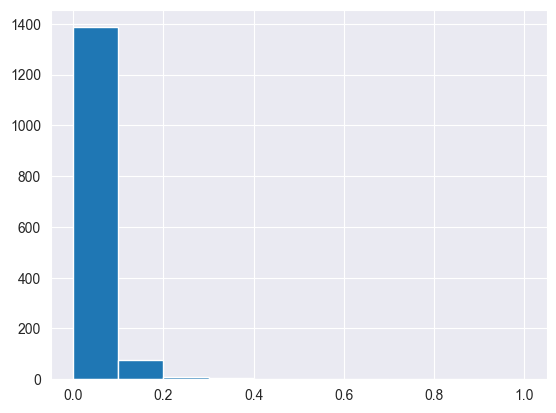

In [18]:
df['price'].hist()

In [19]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   house         1484 non-null   int64  
 1   time          1430 non-null   float64
 2   rooms amount  1484 non-null   int64  
 3   squares       1484 non-null   float64
 4   price         1484 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 58.1 KB


,house,time,rooms amount,squares,price
count,1484.000000,1430.000000,1484.000000,1484.000000,1484.000000
mean,1.113208,0.255385,1.847035,0.092483,0.032987
std,0.323273,0.121817,1.785586,0.101967,0.061725
min,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,1.000000,0.155556,0.000000,0.031995,0.009369
50%,1.000000,0.244444,2.000000,0.059577,0.014122
75%,1.000000,0.355556,3.000000,0.108882,0.036516
max,2.000000,1.000000,9.000000,1.000000,1.000000


<Axes: >

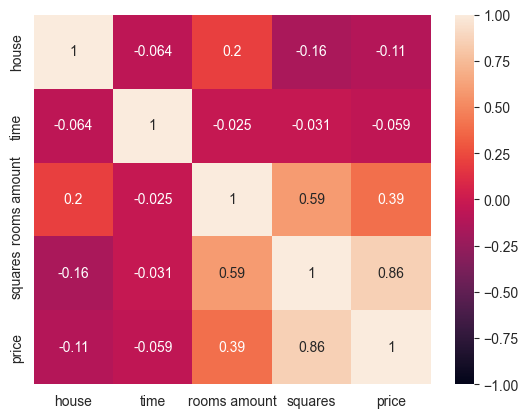

In [20]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

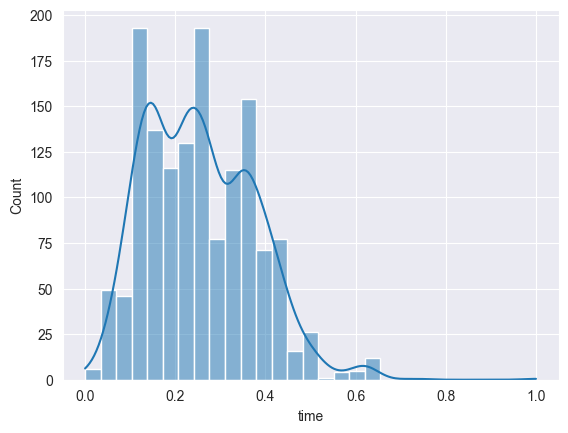

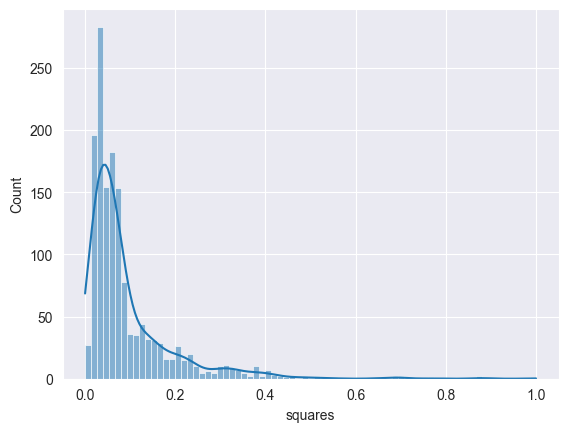

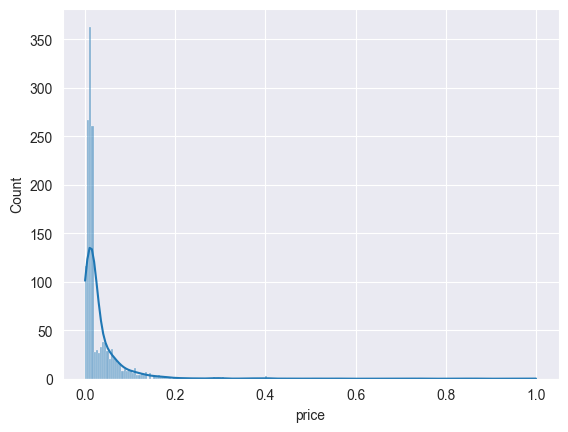

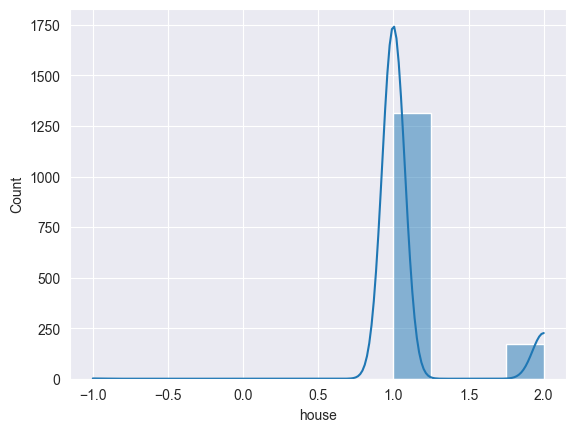

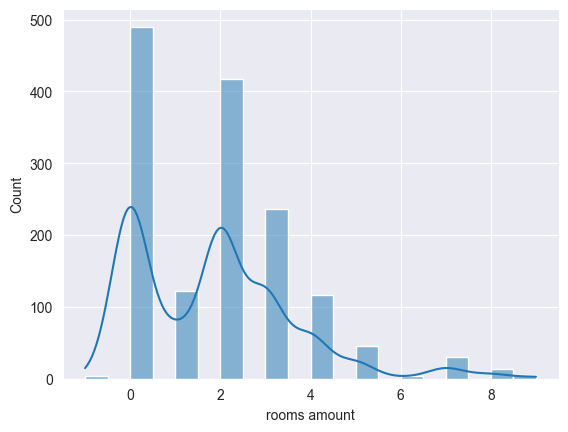

In [21]:
sns.histplot(df['time'], kde=True)
plt.show()

sns.histplot(df['squares'], kde=True)
plt.show()

sns.histplot(df['price'], kde=True)
plt.show()

sns.histplot(df['house'], kde=True) 
plt.show()

sns.histplot(df['rooms amount'], kde=True)
plt.show()

Разделяем переменные

In [22]:
# Разделение данных на признаки (X) и целевую переменную (y)
columns_to_drop = ['price', 'house']
x = df.drop(columns=columns_to_drop, axis=1)
y = df['price']

# train, valid, test
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5)
print(f'train: {len(x_train)}, valid: {len(x_valid)}, test: {len(x_test)}')

train: 890, valid: 297, test: 297


In [23]:
imputer = SimpleImputer(strategy='mean') 

# Заполнение отсутствующих значений в обучающем, валидационном и тестовом наборах
x_train = imputer.fit_transform(x_train)
x_valid = imputer.transform(x_valid)
x_test = imputer.transform(x_test)


In [24]:
def draw(param, _error, _train_scores, _valid_scores, _test_scores, _hyperparameter_values): # Построение графиков
    plt.figure(figsize=(8, 6))
    plt.plot(_hyperparameter_values, _train_scores, label='Train')
    plt.plot(_hyperparameter_values, _valid_scores, label='Validation')
    plt.plot(_hyperparameter_values, _test_scores, label='Test')
    plt.xlabel(param)
    plt.ylabel(_error)
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
class CustomRidge:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        # Добавляем столбец с единицами для учета сдвига
        X = np.c_[np.ones(X.shape[0]), X]
        # Вычисляем веса (коэффициенты)
        X_transpose = np.transpose(X)
        identity = np.identity(X.shape[1])
        self.weights = np.linalg.inv(X_transpose.dot(X) + self.alpha * identity).dot(X_transpose).dot(y)

    def predict(self, X):
        # Добавляем столбец с единицами для учета сдвига
        X = np.c_[np.ones(X.shape[0]), X]
        return X.dot(self.weights)


In [26]:
def model_supervising(_hyperparameter_values, model_name):
    _best_model, min_error = None, float('inf')
    model = None
    _train_scores = []
    _valid_scores = []
    _test_scores = []
    
    for alpha in _hyperparameter_values:
        if model_name == "Ridge":
            model = Ridge(alpha=alpha)
        elif model_name == "CustomRidge":
            model = Ridge(alpha=alpha)
        model.fit(x_train, y_train)
        
        train_pred = model.predict(x_train)
        valid_pred = model.predict(x_valid)
        test_pred = model.predict(x_test)
        
        _train_scores.append(mse(y_train, train_pred))
        _valid_scores.append(mse(y_valid, valid_pred))
        _test_scores.append(mse(y_test, test_pred))
        
        error = mse(valid_pred, y_valid)
        if error < min_error:
            _best_model, min_error = model, error
        
    y_test_prediction = _best_model.predict(x_test)
    test_error = mse(y_test_prediction, y_test)
    
    print(f'Validation error: {min_error}')
    print(f'Test error: {test_error}')
    
    return _train_scores, _valid_scores, _test_scores, _best_model


In [27]:
# Загружаем тренировочные, валидационные и тестовые данные x_train, x_valid, x_test, y_train, y_valid, y_test

alphas = [i + j / 100 for i in range(1, 100) for j in range(100)]

train_scores, valid_scores, test_scores, best_model = model_supervising(alphas, "Ridge")

print(f'best model: {best_model.alpha}')

Validation error: 0.002014253385544735
Test error: 0.001402961572318278
best model: 1.0


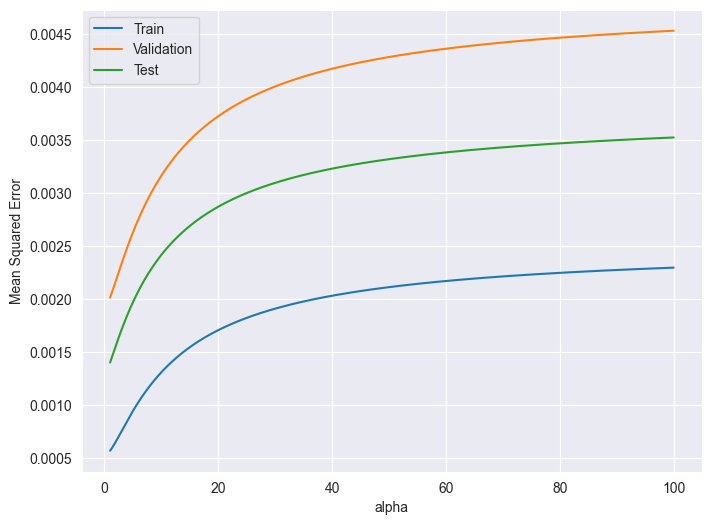

In [28]:
draw('alpha', 'Mean Squared Error', train_scores, valid_scores, test_scores, alphas)

In [29]:
alphas = [i + j / 100 for i in range(1, 100) for j in range(100)]

train_scores, valid_scores, test_scores, best_model = model_supervising(alphas, "CustomRidge")

print(f'best model: {best_model.alpha}')

Validation error: 0.002014253385544735
Test error: 0.001402961572318278
best model: 1.0


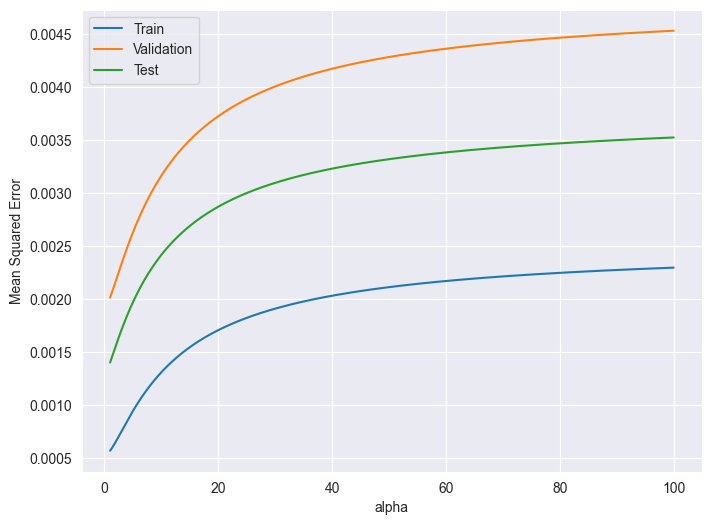

In [30]:
draw('alpha', 'Mean Squared Error', train_scores, valid_scores, test_scores, alphas)